Bibliographie:

https://realpython.com/k-means-clustering-python/ <br>
https://stackoverflow.com/questions/67502519/plot-kmeans-clustering-on-more-than-2-dimensional-data

## 1)  Import packages

In [1]:

import os
import pandas as pd
import numpy as np
from math import ceil

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn import metrics
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

## 2) Import  data

Import the sas table to a pandas dataframe 

In [2]:
dataset = pd.read_sas('../data/a2z_insurance.sas7bdat')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10279 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [4]:
dataset.head()

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   
1     2.0        1981.0     1995.0  b'2 - High School'     677.0         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

In [5]:
dataset.shape

(10296, 14)

We have 10k observations available and 14 variables

Do we have any duplicated rows?

In [6]:
dataset.duplicated().sum()

0

We dont have any duplicates

Lets drop customer ID

In [7]:
dataset.drop('CustID', axis=1, inplace=True)

In [8]:
dataset.duplicated().sum()

3

If we dont consider the CustID we have 3 identical rows. Could this be the same client with different client numbers?
Lets drop these rows

In [9]:
dataset.drop_duplicates(keep='first', inplace=True)

In [10]:
dataset.shape

(10293, 13)

## Data Exploration

In [11]:
## create a new dataset to maintain the original
data_exp = dataset.copy()

In [12]:
## Let me create two variables that will allow me to explore better my data: client tenure and age
data_exp['ClientTenure'] = 2016-data_exp['FirstPolYear']
data_exp['ClientAge'] = 2016-data_exp['BirthYear']

data_exp.drop(columns=['FirstPolYear','BirthYear'], inplace=True)

In [13]:
data_exp.describe().T

count         mean          std        min      25%      50%  \
MonthSal       10257.0  2506.618699  1157.518390     333.00  1706.00  2502.00   
GeoLivArea     10292.0     2.709483     1.266284       1.00     1.00     3.00   
Children       10272.0     0.706776     0.455263       0.00     0.00     1.00   
CustMonVal     10293.0   177.929963  1946.091554 -165680.42    -9.44   187.03   
ClaimsRate     10293.0     0.742728     2.917385       0.00     0.39     0.72   
PremMotor      10259.0   300.501550   211.937740      -4.11   190.59   298.61   
PremHousehold  10293.0   210.419863   352.635041     -75.00    49.45   132.80   
PremHealth     10250.0   171.553183   296.444399      -2.11   111.80   162.81   
PremLife       10189.0    41.848724    47.484264      -7.00     9.89    25.56   
PremWork       10207.0    41.283712    51.519022     -12.00    10.67    25.67   
ClientTenure   10263.0    24.935107   511.342617  -51768.00    24.00    30.00   
ClientAge      10276.0    47.993091    19.710742      15.00    33.00    48.00   

                   75%       max  
MonthSal       3290.00  55215.00  
GeoLivArea        4.00      4.00  
Children          1.00      1.00  
CustMonVal      399.86  11875.89  
ClaimsRate        0.98    256.20  
PremMotor       408.30  11604.42  
PremHousehold   290.05  25048.80  
PremHealth      219.04  28272.00  
PremLife         57.79    398.30  
PremWork         56.79   1988.70  
ClientTenure     36.00     42.00  
ClientAge        63.00    988.00

- Age has a max of 988 years
- Client tenure has a min of -51 768 yrs
- There is someone that earn 55k per month
- There are clients with negative premiums
- one client has 256% of claim rate, a really bad client
- ~71% of the clients have children

There are some nulls for the premium variables. I'm going to treat this ones now and the rest I will analyse further ahead.

I know that there are clients with negative premiums and this may mean they canceled a policy in the previous year. Because I dont know all the others if they canceled or not I will put these values to zero

In [14]:
data_exp.describe(include='O').T

count unique             top  freq
EducDeg  10276      4  b'3 - BSc/MSc'  4799

In [15]:
# before setting the negative I will mark them

data_exp['MotorCancelled'] = np.where(data_exp['PremMotor']<0,1,0)
data_exp['HomeCancelled'] = np.where(data_exp['PremHousehold']<0,1,0)
data_exp['HealthCancelled'] = np.where(data_exp['PremHealth']<0,1,0)
data_exp['LifeCancelled'] = np.where(data_exp['PremLife']<0,1,0)
data_exp['WorkCancelled'] = np.where(data_exp['PremWork']<0,1,0)

data_exp['TotalCancelled'] = data_exp['MotorCancelled']+data_exp['HomeCancelled']+data_exp['HealthCancelled']+data_exp['LifeCancelled']+data_exp['WorkCancelled']

data_exp['Cancelled'] = np.where(data_exp['TotalCancelled']>0,1,0)
                                                                                           
# replaces negative values for zeros
data_exp['PremMotor'] = np.where(data_exp['PremMotor']<0,0,data_exp['PremMotor'])
data_exp['PremHousehold'] = np.where(data_exp['PremHousehold']<0,0,data_exp['PremHousehold'])
data_exp['PremHealth'] = np.where(data_exp['PremHealth']<0,0,data_exp['PremHealth'])
data_exp['PremLife'] = np.where(data_exp['PremLife']<0,0,data_exp['PremLife'])
data_exp['PremWork'] = np.where(data_exp['PremWork']<0,0,data_exp['PremWork'])

# will consider that premiums missing is because client does not own the product
data_exp['PremMotor'].fillna(0, inplace=True)
data_exp['PremHousehold'].fillna(0, inplace=True)
data_exp['PremHealth'].fillna(0, inplace=True)
data_exp['PremLife'].fillna(0, inplace=True)
data_exp['PremWork'].fillna(0, inplace=True)

In [16]:
data_exp.isna().sum()

EducDeg            17
MonthSal           36
GeoLivArea          1
Children           21
CustMonVal          0
ClaimsRate          0
PremMotor           0
PremHousehold       0
PremHealth          0
PremLife            0
PremWork            0
ClientTenure       30
ClientAge          17
MotorCancelled      0
HomeCancelled       0
HealthCancelled     0
LifeCancelled       0
WorkCancelled       0
TotalCancelled      0
Cancelled           0
dtype: int64

Before we start analyzing the data lets have a first look to the correlations. This will allow me to understand each variables I will use of not in my segmentation and will influence if I need to treat them or not. Will also allow me to understand maybe the dimensions I want to use in my segmentation (not too correlated but not completly independent)

In [17]:
class_features = ['EducDeg']
metric_features = list(data_exp.columns[~data_exp.columns.isin(class_features)])

In [18]:
print(metric_features)

['MonthSal', 'GeoLivArea', 'Children', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'ClientTenure', 'ClientAge', 'MotorCancelled', 'HomeCancelled', 'HealthCancelled', 'LifeCancelled', 'WorkCancelled', 'TotalCancelled', 'Cancelled']


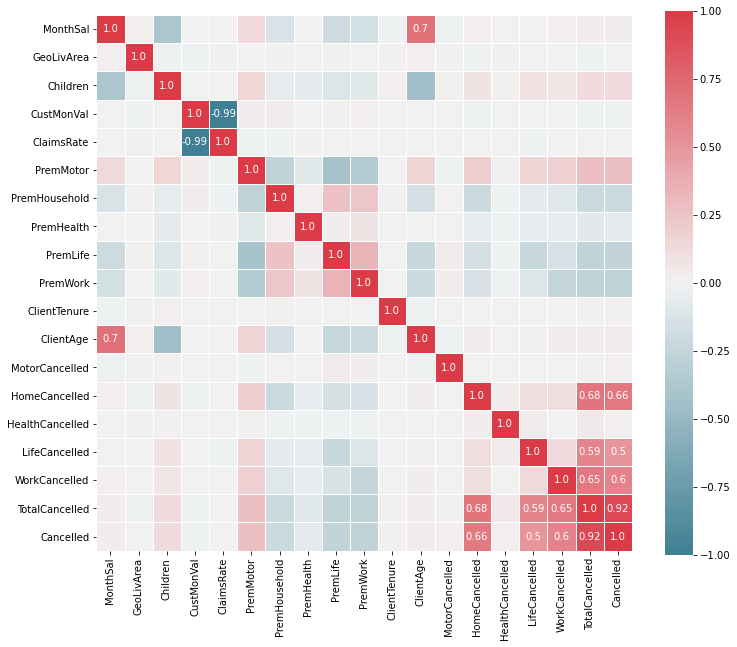

In [19]:
# builds correlation matrix
corre = round(data_exp[metric_features].corr(),2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corre.values) >= 0.5
annot = np.where(mask_annot, corre.values, np.full(corre.shape,"")) # Try to understand what this np.where() does

# Prepare figure
fig = plt.figure(figsize=(12, 10))
# Plot heatmap of the correlation matrix
sns.heatmap(data=corre, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

- Client age and Monthly salary are obviously correlated but I will still keep both
- Claims rate and customer value have a perfect correlation and are not really correlated with any variable else
- Client tenure is not correlated with any other variables

In [20]:
## check the matrix
corre

MonthSal  GeoLivArea  Children  CustMonVal  ClaimsRate  \
MonthSal             1.00        0.02     -0.39       -0.00       -0.00   
GeoLivArea           0.02        1.00     -0.02       -0.01        0.01   
Children            -0.39       -0.02      1.00       -0.00       -0.00   
CustMonVal          -0.00       -0.01     -0.00        1.00       -0.99   
ClaimsRate          -0.00        0.01     -0.00       -0.99        1.00   
PremMotor            0.14        0.00      0.15        0.03       -0.01   
PremHousehold       -0.13        0.01     -0.06        0.03       -0.01   
PremHealth          -0.00        0.00     -0.07        0.00        0.01   
PremLife            -0.20        0.01     -0.11        0.01        0.00   
PremWork            -0.17        0.00     -0.08        0.02       -0.00   
ClientTenure        -0.01        0.01      0.02       -0.00        0.00   
ClientAge            0.70        0.02     -0.44       -0.00       -0.00   
MotorCancelled      -0.02        0.01      0.01       -0.00        0.00   
HomeCancelled        0.02       -0.02      0.08       -0.01        0.00   
HealthCancelled      0.00        0.01      0.01        0.00       -0.00   
LifeCancelled        0.00       -0.00      0.09        0.00       -0.01   
WorkCancelled        0.02        0.00      0.07       -0.00       -0.00   
TotalCancelled       0.03       -0.01      0.12       -0.01       -0.00   
Cancelled            0.03       -0.00      0.12       -0.01       -0.00   

                 PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
MonthSal              0.14          -0.13       -0.00     -0.20     -0.17   
GeoLivArea            0.00           0.01        0.00      0.01      0.00   
Children              0.15          -0.06       -0.07     -0.11     -0.08   
CustMonVal            0.03           0.03        0.00      0.01      0.02   
ClaimsRate           -0.01          -0.01        0.01      0.00     -0.00   
PremMotor             1.00          -0.27       -0.08     -0.41     -0.34   
PremHousehold        -0.27           1.00        0.02      0.26      0.24   
PremHealth           -0.08           0.02        1.00      0.03      0.08   
PremLife             -0.41           0.26        0.03      1.00      0.34   
PremWork             -0.34           0.24        0.08      0.34      1.00   
ClientTenure         -0.00           0.01       -0.00      0.00      0.00   
ClientAge             0.16          -0.15       -0.00     -0.23     -0.21   
MotorCancelled       -0.01           0.00       -0.00      0.04      0.03   
HomeCancelled         0.20          -0.21       -0.05     -0.16     -0.14   
HealthCancelled       0.01          -0.01       -0.01     -0.01     -0.01   
LifeCancelled         0.16          -0.07       -0.05     -0.23     -0.11   
WorkCancelled         0.18          -0.10       -0.05     -0.14     -0.25   
TotalCancelled        0.28          -0.21       -0.08     -0.27     -0.27   
Cancelled             0.27          -0.21       -0.07     -0.26     -0.27   

                 ClientTenure  ClientAge  MotorCancelled  HomeCancelled  \
MonthSal                -0.01       0.70           -0.02           0.02   
GeoLivArea               0.01       0.02            0.01          -0.02   
Children                 0.02      -0.44            0.01           0.08   
CustMonVal              -0.00      -0.00           -0.00          -0.01   
ClaimsRate               0.00      -0.00            0.00           0.00   
PremMotor               -0.00       0.16           -0.01           0.20   
PremHousehold            0.01      -0.15            0.00          -0.21   
PremHealth              -0.00      -0.00           -0.00          -0.05   
PremLife                 0.00      -0.23            0.04          -0.16   
PremWork                 0.00      -0.21            0.03          -0.14   
ClientTenure             1.00      -0.01            0.00           0.00   
ClientAge               -0.01       1.00           -0.01           0.03   


In [21]:
#data_exp.drop(['CustMonVal','ClaimsRate'], axis=1, inplace=True)

In [22]:
# # Prepare figure. Create individual axes where each histogram will be placed
# fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# # Plot data
# # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
# for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
#     ax.hist(data_exp[feat])
#     ax.set_title(feat, y=-0.13)
    
# # Layout
# # Add a centered title to the figure:
# title = "Numeric Variables' Histograms"

# plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
# plt.show()

The dataset has a lot of outliers. Lets do one at the time to analyze.

In [23]:
data_exp[data_exp['ClientTenure']==-51768]

EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  ClaimsRate  \
9294  b'3 - BSc/MSc'    3268.0         1.0       0.0      348.85        0.37   

      PremMotor  PremHousehold  PremHealth  PremLife  PremWork  ClientTenure  \
9294      351.4           15.0      187.37     22.45     17.78      -51768.0   

      ClientAge  MotorCancelled  HomeCancelled  HealthCancelled  \
9294       68.0               0              0                0   

      LifeCancelled  WorkCancelled  TotalCancelled  Cancelled  
9294              0              0               0          0

In [24]:
# because its only strange value for this variable and for this client, I will assume is an error and will be NaN
data_exp['ClientTenure'].replace(-51768, None, inplace=True)

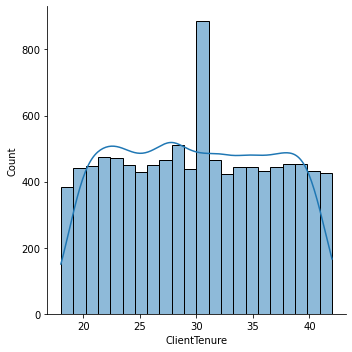

In [25]:
##plot client tenure
sns.displot(data= data_exp, x='ClientTenure', kde=True)
plt.show()

## there is a even distribution of tenures with a spik at 30 years of tenure. I would expect a more normal distribution

In [26]:
data_exp[data_exp['ClientAge']==988]

EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  ClaimsRate  \
7195  b'3 - BSc/MSc'    2830.0         4.0       0.0      146.02        0.77   

      PremMotor  PremHousehold  PremHealth  PremLife  PremWork  ClientTenure  \
7195     428.97          192.8      108.91      1.89     23.67          23.0   

      ClientAge  MotorCancelled  HomeCancelled  HealthCancelled  \
7195      988.0               0              0                0   

      LifeCancelled  WorkCancelled  TotalCancelled  Cancelled  
7195              0              0               0          0

In [27]:
# same logic as ClientTenure here for ClientAge
data_exp['ClientAge'].replace(988, None, inplace=True)

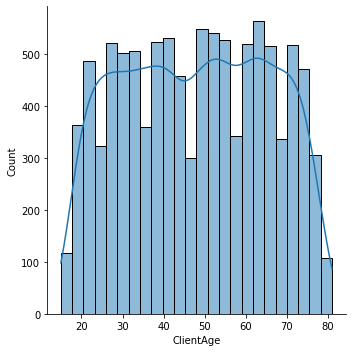

In [28]:
##plot client tenure
sns.displot(data= data_exp, x='ClientAge', kde=True)
plt.show()

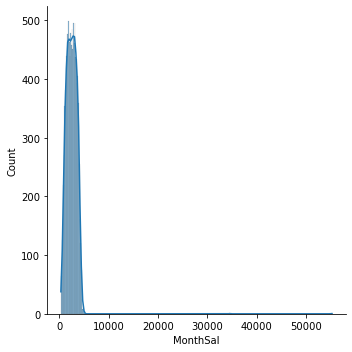

In [29]:
# Plot Monthly Salary
sns.displot(data= data_exp, x='MonthSal', kde=True)
plt.show()

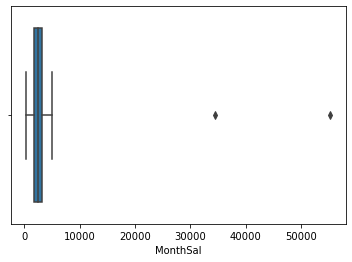

In [30]:
sns.boxplot(data= data_exp, x='MonthSal')
plt.show()

In [31]:
# Filter clients with a montly salary higher or equal to 3k - not losing the missings
data_exp = data_exp[(data_exp['MonthSal']<30000) | (data_exp['MonthSal'].isna())]

In [32]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.95 of the original data


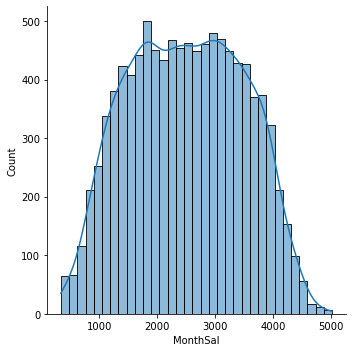

In [33]:
##plot monthly salary
sns.displot(data= data_exp, x='MonthSal', kde=True)
plt.show()

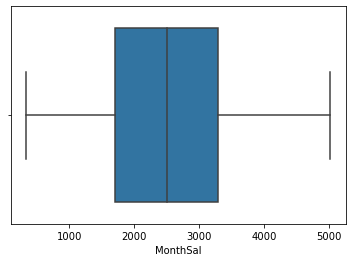

In [34]:
sns.boxplot(data= data_exp, x='MonthSal')
plt.show()

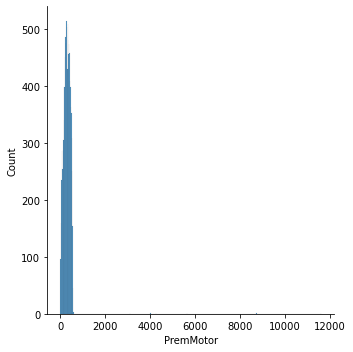

In [35]:
# Motor Premims
sns.displot(data=data_exp, x=data_exp['PremMotor'])
plt.show()

As we saw there is a client with 12k motor premium. Lets remove the client

In [36]:
# how many clients have a premium higher than 2k ?
data_exp[data_exp['PremMotor']>=2000] #7

EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  \
5128        b'1 - Basic'    3763.0         1.0       0.0      466.21   
5211  b'2 - High School'    4135.0         3.0       0.0      130.14   
5293      b'3 - BSc/MSc'    3564.0         3.0       1.0    11875.89   
6701      b'3 - BSc/MSc'    2947.0         4.0       0.0     4328.50   
7085      b'3 - BSc/MSc'    2460.0         3.0       1.0     5596.84   
7904      b'3 - BSc/MSc'    2354.0         4.0       1.0      -46.89   

      ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
5128        0.90    4003.44          612.9      137.36    121.69     31.34   
5211        0.99    8744.61          101.7     1767.00    155.14    130.58   
5293        0.09   11604.42           48.9     1045.52    103.13    296.47   
6701        0.03    4273.49           83.9      105.13      3.00      3.89   
7085        0.01    5645.50            0.0       49.01      1.89      1.89   
7904        1.01    3106.62           30.0       59.01     12.89      9.00   

      ClientTenure  ClientAge  MotorCancelled  HomeCancelled  HealthCancelled  \
5128          20.0       73.0               0              0                0   
5211          35.0       73.0               0              0                0   
5293          27.0       53.0               0              0                0   
6701          21.0       65.0               0              0                0   
7085          24.0       53.0               0              1                0   
7904          42.0       57.0               0              0                0   

      LifeCancelled  WorkCancelled  TotalCancelled  Cancelled  
5128              0              0               0          0  
5211              0              0               0          0  
5293              0              0               0          0  
6701              0              0               0          0  
7085              0              0               1          1  
7904              0              0               0          0

In [37]:
# Filter clients with a motor premium higher or equal to 2k
data_exp = data_exp[data_exp['PremMotor']<2000]

In [38]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.89 of the original data


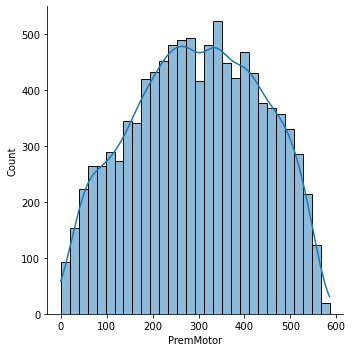

In [39]:
# Motor Premims
sns.displot(data=data_exp, x=data_exp['PremMotor'], kde=True)
plt.show()

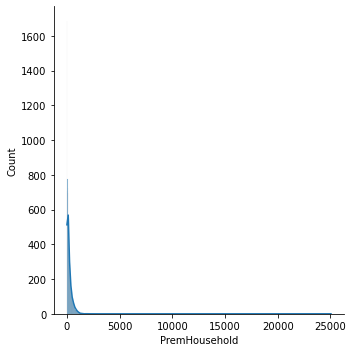

In [40]:
# Home Premims
sns.displot(data=data_exp, x=data_exp['PremHousehold'], kde=True)
plt.show()

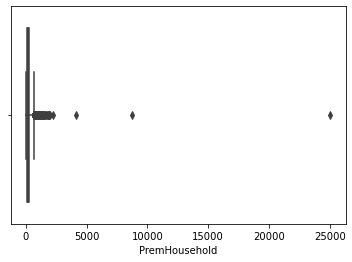

In [41]:
sns.boxplot(data= data_exp, x='PremHousehold')
plt.show()

In [42]:
# how many clients have a premium higher than 4k ?
data_exp[data_exp['PremHousehold']>=4000] #3

EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  \
6343  b'2 - High School'    2642.0         2.0       1.0        0.78   
6835      b'3 - BSc/MSc'    2832.0         4.0       1.0      -31.00   
8866  b'2 - High School'    2618.0         4.0       1.0      473.54   

      ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
6343        0.99     424.19         4130.7      118.69     15.67     41.45   
6835        1.00     535.10         8762.8       41.12      0.00      9.78   
8866        0.98     508.43        25048.8       36.23      9.89     11.89   

      ClientTenure  ClientAge  MotorCancelled  HomeCancelled  HealthCancelled  \
6343          35.0       67.0               0              0                0   
6835          41.0       50.0               0              0                0   
8866          38.0       44.0               0              0                0   

      LifeCancelled  WorkCancelled  TotalCancelled  Cancelled  
6343              0              0               0          0  
6835              1              0               1          1  
8866              0              0               0          0

In [43]:
# Filter clients with a home premium higher or equal to 4k
data_exp = data_exp[data_exp['PremHousehold']<1500]

In [44]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.76 of the original data


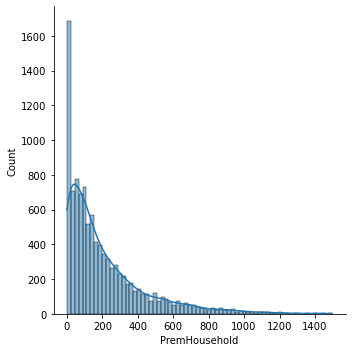

In [45]:
# Home Premims
sns.displot(data=data_exp, x=data_exp['PremHousehold'], kde=True)
plt.show()

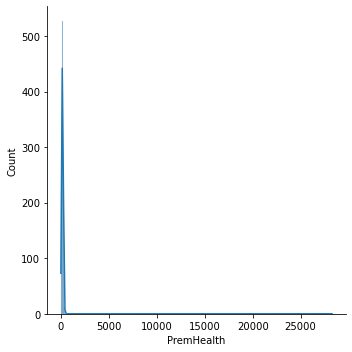

In [46]:
# Health Premims
sns.displot(data=data_exp, x=data_exp['PremHealth'], kde=True)
plt.show()

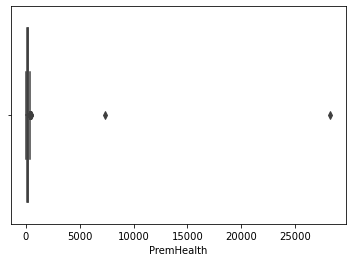

In [47]:
sns.boxplot(data= data_exp, x='PremHealth')
plt.show()

In [48]:
data_exp[data_exp['PremHealth']>5000]

EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  \
7961      b'3 - BSc/MSc'    4002.0         3.0       0.0     1457.99   
9149  b'2 - High School'     987.0         3.0       1.0      804.05   

      ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
7961        0.83     431.86         107.80     7322.48     12.89    930.44   
9149        0.97      26.34         829.05    28272.00     65.68    138.25   

      ClientTenure  ClientAge  MotorCancelled  HomeCancelled  HealthCancelled  \
7961          21.0       74.0               0              0                0   
9149          31.0       22.0               0              0                0   

      LifeCancelled  WorkCancelled  TotalCancelled  Cancelled  
7961              0              0               0          0  
9149              0              0               0          0

In [49]:
data_exp = data_exp[data_exp['PremHealth']<5000]

In [50]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.74 of the original data


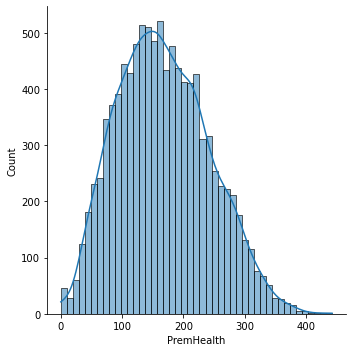

In [51]:
# Health Premims
sns.displot(data=data_exp, x=data_exp['PremHealth'], kde=True)
plt.show()

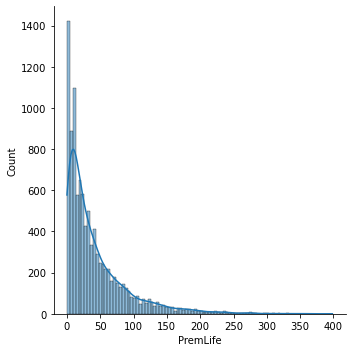

In [52]:
# Life Premims
sns.displot(data=data_exp, x=data_exp['PremLife'], kde=True)
plt.show()

In [53]:
data_exp = data_exp[data_exp['PremLife']<250]

In [54]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.25 of the original data


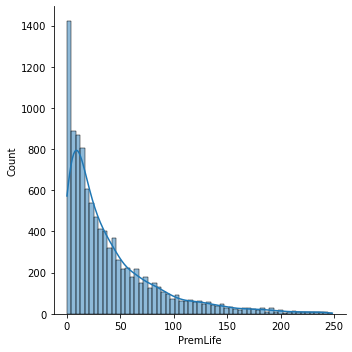

In [55]:
# Life Premims
sns.displot(data=data_exp, x=data_exp['PremLife'], kde=True)
plt.show()

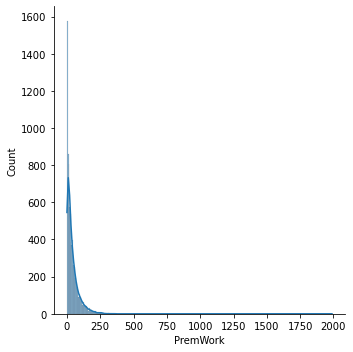

In [56]:
# Wokers Comp Premims
sns.displot(data=data_exp, x=data_exp['PremWork'], kde=True)
plt.show()

In [57]:
data_exp = data_exp[data_exp['PremWork']<300]

In [58]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.10 of the original data


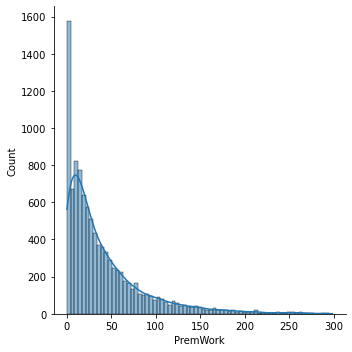

In [59]:
# Wokers Comp Premims
sns.displot(data=data_exp, x=data_exp['PremWork'], kde=True)
plt.show()

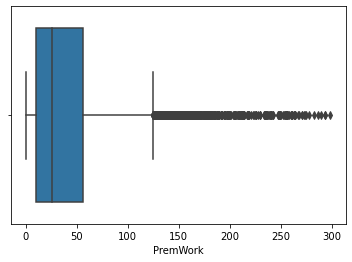

In [60]:
sns.boxplot(data= data_exp, x='PremWork')
plt.show()

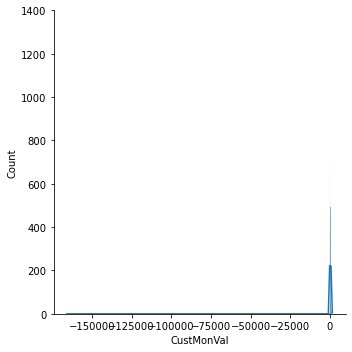

In [61]:
# Costumer Value
sns.displot(data=data_exp, x=data_exp['CustMonVal'], kde=True)
plt.show()

In [62]:
data_exp = data_exp[data_exp['CustMonVal']>=-2000]

In [63]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 98.96 of the original data


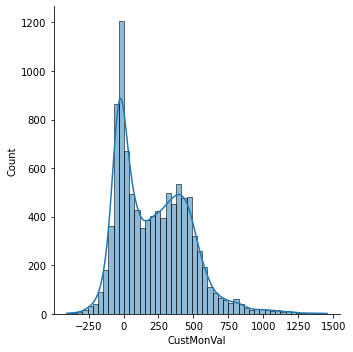

In [64]:
# Costumer Value
sns.displot(data=data_exp, x=data_exp['CustMonVal'], kde=True)
plt.show()

### Categorical variables

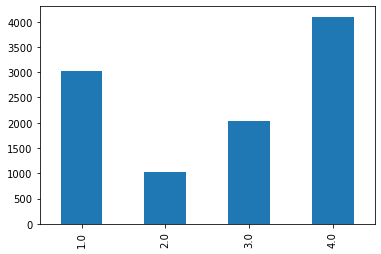

In [65]:
data_exp['GeoLivArea'].value_counts().sort_index().plot(kind='bar')
plt.show()

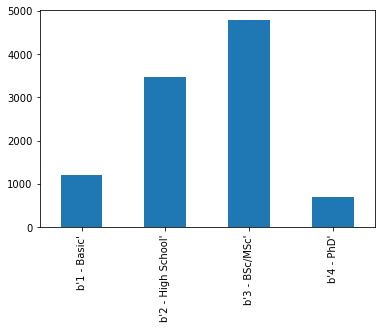

In [66]:
data_exp['EducDeg'].value_counts().sort_index().plot(kind='bar')
plt.show()

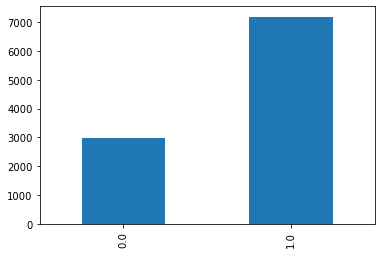

In [67]:
data_exp['Children'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [68]:
data_exp.drop(columns=['TotalCancelled','WorkCancelled','LifeCancelled','HealthCancelled','HomeCancelled','MotorCancelled'], inplace=True)

## 3) Data preprocessing

Lets take a look again to the data

In [69]:
data_exp.describe().T

count         mean         std     min      25%      50%  \
MonthSal       10153.0  2508.012903  979.527183  333.00  1723.00  2513.00   
GeoLivArea     10188.0     2.707892    1.266752    1.00     1.00     3.00   
Children       10168.0     0.707022    0.455151    0.00     0.00     1.00   
CustMonVal     10189.0   216.775431  253.803244 -406.07    -9.22   186.27   
ClaimsRate     10189.0     0.680472    0.320094    0.00     0.39     0.72   
PremMotor      10189.0   297.816492  137.790104    0.00   192.48   299.39   
PremHousehold  10189.0   207.172755  226.585864    0.00    49.45   132.25   
PremHealth     10189.0   167.661381   74.765203    0.00   111.80   162.92   
PremLife       10189.0    40.357309   43.950665    0.00     9.78    24.67   
PremWork       10189.0    40.483303   44.810353    0.00     9.89    25.45   
ClientTenure   10159.0    29.977458    6.608402   18.00    24.00    30.00   
ClientAge      10172.0    48.087102   17.292986   15.00    33.00    48.00   
Cancelled      10189.0     0.217980    0.412894    0.00     0.00     0.00   

                   75%      max  
MonthSal       3293.00  5021.00  
GeoLivArea        4.00     4.00  
Children          1.00     1.00  
CustMonVal      398.08  1455.94  
ClaimsRate        0.98     4.33  
PremMotor       408.30   585.22  
PremHousehold   285.60  1498.05  
PremHealth      219.82   442.86  
PremLife         56.01   248.27  
PremWork         55.79   298.50  
ClientTenure     36.00    42.00  
ClientAge        63.00    81.00  
Cancelled         0.00     1.00

<b> Validation the data </b>

In [70]:
# Creating a new dataframe
data_prep = data_exp.copy()

In [71]:
# Clients where the client tenure is higher than their age
len(data_prep.loc[data_prep['ClientTenure']>data_prep['ClientAge']])

1927

In [72]:
round(len(data_prep.loc[data_prep['ClientTenure']>data_prep['ClientAge']])/len(data_prep),3)

0.189

~2k clients have a policy which is older than them. It represent 20% of the data 

- Age is very correlated with monthly salary. in montly salary I just have 36 missings. so I will keep MonthSal and drop ClientAge
- Age is in general more correlated with other variables (premium variables) than salary. that is obvious since age is used by insurance companies in their tariffs. younger customers generaly have higher premiums, not because they bring more value but because they represent a higher risk (more claims)
- Motor premiums have a great contribution for client TotalPremiums and very correlated with age. younger drivers have more claims on average
- So using age in my opinion will not compute meaningfull clusters

<b> Lets treat the rest of the missing data </b>

In [73]:
data_prep.isna().sum()

EducDeg          17
MonthSal         36
GeoLivArea        1
Children         21
CustMonVal        0
ClaimsRate        0
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
ClientTenure     30
ClientAge        17
Cancelled         0
dtype: int64

I am thinking about creating a predictive model to estimate MonthSal to fill nan <br>
Possible explanatory variables = EducDeg, AgeClient, GeoLivArea, Children


In [74]:
# how many clients have MonthSal and ClientAge missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.ClientAge.isna())]))

0


In [75]:
# how many clients have MonthSal and EducDeg missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.EducDeg.isna())]))

1


In [76]:
# how many clients have MonthSal and GeoLivArea missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.GeoLivArea.isna())]))

0


In [77]:
# how many clients have MonthSal and GeoLivArea missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.Children.isna())]))

0


Only 1  client has EducDeg and MonthSal missing the rest of the clients are ok

In [78]:
# theres 1 client with GeoLivArea missing. I will not use this variable in my clusters but I will use to impute the other 
# variables so I will drop it
data_prep.dropna(subset=['EducDeg'], inplace=True)

In [79]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 98.96 of the original data


In [80]:
# Monthly Salary
# I saw already that age is correlated with montly salary but maybe eductation level is too
# what is the average salary by education level
data_prep.groupby('EducDeg')['MonthSal'].median()

EducDeg
b'1 - Basic'          1794.5
b'2 - High School'    2508.5
b'3 - BSc/MSc'        2615.0
b'4 - PhD'            2645.0
Name: MonthSal, dtype: float64

- Higher degree greater the average salary

In [81]:
# Indeed we see that higher the education higher the monthly salary
# Also works for living area?
# what is the average salary by education level
data_prep.groupby('GeoLivArea')['MonthSal'].mean()

GeoLivArea
1.0    2481.500499
2.0    2564.571568
3.0    2494.657284
4.0    2517.537141
Name: MonthSal, dtype: float64

- living area 2 and 4 have higher average salaries compared with 1 and 3. but is it really different?

In [82]:
data_prep.groupby('Children')['MonthSal'].mean()

Children
0.0    3216.119771
1.0    2213.694911
Name: MonthSal, dtype: float64

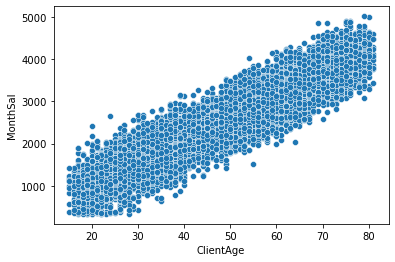

In [83]:
# relation between age and salary

sns.scatterplot(data=data_prep, x='ClientAge',y='MonthSal')
plt.show()

In [84]:
# I will try to predict clients monthly salary based on this 3 variables

# encoding level of education
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'1 - Basic', 'Basic', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'2 - High School', 'HighSchool', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'3 - BSc/MSc', 'BscMsc', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'4 - PhD', 'PhD', data_prep['EducDeg'])

educ_dummys = pd.get_dummies(data_prep['EducDeg'], prefix='Educ')

In [85]:
educ_dummys.head()

Educ_Basic  Educ_BscMsc  Educ_HighSchool  Educ_PhD
0           0            0                1         0
1           0            0                1         0
2           1            0                0         0
3           0            1                0         0
4           0            1                0         0

In [86]:
# I want to change the type to int and for that I need to impute the missing value since ints cannot have nan values
data_prep['GeoLivArea'].fillna(data_prep['GeoLivArea'].mode()[0], inplace=True)
data_prep['GeoLivArea'] = data_prep['GeoLivArea'].astype('int32')
liv_dummys = pd.get_dummies(data_prep['GeoLivArea'], prefix='LivArea')

In [87]:
liv_dummys.head()

LivArea_1  LivArea_2  LivArea_3  LivArea_4
0          1          0          0          0
1          0          0          0          1
2          0          0          1          0
3          0          0          0          1
4          0          0          0          1

In [88]:
## merge the data
data_prep = pd.concat([data_prep,educ_dummys,liv_dummys], axis=1)
data_prep.head()

EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  ClaimsRate  \
0  HighSchool    2177.0           1       1.0      380.97        0.39   
1  HighSchool     677.0           4       1.0     -131.13        1.12   
2       Basic    2277.0           3       0.0      504.67        0.28   
3      BscMsc    1099.0           4       1.0      -16.99        0.99   
4      BscMsc    1763.0           4       1.0       35.23        0.90   

   PremMotor  PremHousehold  PremHealth  PremLife  ...  ClientAge  Cancelled  \
0     375.85          79.45      146.36     47.01  ...       34.0          0   
1      77.46         416.20      116.69    194.48  ...       21.0          0   
2     206.15         224.50      124.58     86.35  ...       46.0          0   
3     182.48          43.35      311.17     35.34  ...       35.0          0   
4     338.62          47.80      182.59     18.78  ...       43.0          0   

   Educ_Basic  Educ_BscMsc  Educ_HighSchool  Educ_PhD  LivArea_1  LivArea_2  \
0           0            0                1         0          1          0   
1           0            0                1         0          0          0   
2           1            0                0         0          0          0   
3           0            1                0         0          0          0   
4           0            1                0         0          0          0   

   LivArea_3  LivArea_4  
0          0          0  
1          0          1  
2          1          0  
3          0          1  
4          0          1  

[5 rows x 22 columns]

In [89]:
# to train the models I need to take the missings
ms_impute = data_prep.dropna()

In [90]:
# Predictig MonthSal 
features = ['ClientAge','Educ_Basic','Educ_HighSchool','Educ_BscMsc','Educ_PhD','LivArea_1','LivArea_2','LivArea_3','LivArea_4','Children']
X_train = ms_impute[features]
y_train = ms_impute.MonthSal

In [91]:
DecisionTree = DecisionTreeRegressor().fit(X_train,y_train)

In [92]:
# from sklearn import tree
# plt.figure(figsize=(50,50))
# tree.plot_tree(DecisionTree,feature_names=features, filled=True)
# plt.show()

In [93]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, DecisionTree.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, DecisionTree.predict(X_train))**(1/2))))

R2 Score: 0.88
RMSE: 338.22


In [94]:
LinearRegressor = LinearRegression().fit(X_train,y_train)

In [95]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, LinearRegressor.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, LinearRegressor.predict(X_train))**(1/2))))

R2 Score: 0.86
RMSE: 369.31


In [96]:
RandomForest = RandomForestRegressor().fit(X_train,y_train)
GradientBoost = GradientBoostingRegressor().fit(X_train,y_train)

In [97]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, RandomForest.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, RandomForest.predict(X_train))**(1/2))))

R2 Score: 0.88
RMSE: 339.51


In [98]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, GradientBoost.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, GradientBoost.predict(X_train))**(1/2))))

R2 Score: 0.86
RMSE: 364.79


In [99]:
# reset index for row iteration since we already drop some columns
data_prep.reset_index(inplace=True)

In [100]:
for i in range(len(data_prep)):
    if pd.isnull(data_prep.iloc[i]['MonthSal']) == True:
        data_prep['MonthSal'].iloc[i] = DecisionTree.predict(pd.DataFrame(data_prep.iloc[i][features]).T)[0]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [101]:
data_exp.loc[(data_exp['MonthSal'].isna()) & (data_exp['EducDeg'] == b'4 - PhD')]

EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  ClaimsRate  \
3227  b'4 - PhD'       NaN         1.0       0.0        8.12        0.87   

      PremMotor  PremHousehold  PremHealth  PremLife  PremWork  ClientTenure  \
3227      225.6            0.0         0.0     19.56     13.56          26.0   

      ClientAge  Cancelled  
3227       67.0          0

In [102]:
data_prep.loc[data_prep['index']==3227]

index EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  ClaimsRate  \
3185   3227     PhD  3631.375           1       0.0        8.12        0.87   

      PremMotor  PremHousehold  PremHealth  ...  ClientAge  Cancelled  \
3185      225.6            0.0         0.0  ...       67.0          0   

      Educ_Basic  Educ_BscMsc  Educ_HighSchool  Educ_PhD  LivArea_1  \
3185           0            0                0         1          1   

      LivArea_2  LivArea_3  LivArea_4  
3185          0          0          0  

[1 rows x 23 columns]

In [103]:
data_prep.loc[data_prep['index']==21]

index     EducDeg     MonthSal  GeoLivArea  Children  CustMonVal  \
20     21  HighSchool  3277.333333           3       1.0      111.37   

    ClaimsRate  PremMotor  PremHousehold  PremHealth  ...  ClientAge  \
20         0.8     407.52          111.7      100.13  ...       58.0   

    Cancelled  Educ_Basic  Educ_BscMsc  Educ_HighSchool  Educ_PhD  LivArea_1  \
20          0           0            0                1         0          0   

    LivArea_2  LivArea_3  LivArea_4  
20          0          1          0  

[1 rows x 23 columns]

In [104]:
## impute discrete and categorical varibles with the mode
# these variables I will not use for clusters but only for interpretation

data_prep['ClientAge'].fillna(data_prep['ClientAge'].mode()[0],inplace=True)
data_prep['ClientTenure'].fillna(data_prep['ClientTenure'].mode()[0],inplace=True)
data_prep['EducDeg'].fillna(data_prep['EducDeg'].mode()[0],inplace=True)
data_prep['GeoLivArea'].fillna(data_prep['GeoLivArea'].mode()[0],inplace=True)
data_prep['Children'].fillna(data_prep['Children'].mode()[0],inplace=True)

In [105]:
# Creating new variables
data_prep['TotalPremiums'] = data_prep['PremMotor']+data_prep['PremHousehold']+data_prep['PremHealth']+data_prep['PremLife']+data_prep['PremWork']
data_prep['ClaimsCost'] = data_prep['ClaimsRate'] * data_prep['TotalPremiums']
data_prep['ClientMargin'] = data_prep['TotalPremiums']-data_prep['ClaimsCost']
data_prep['YearSal'] = data_prep['MonthSal']*14
data_prep['EffortRate'] = data_prep['TotalPremiums']/data_prep['YearSal']

In [106]:
data_prep.set_index('index', inplace=True)

In [107]:
data_prep.drop(['ClaimsRate'], axis=1, inplace=True)

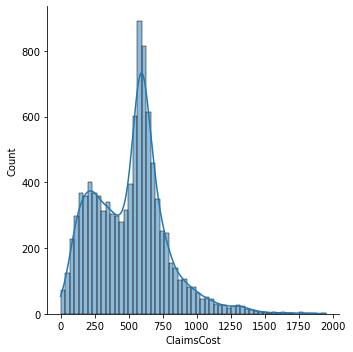

In [108]:
##plot claims cost
sns.displot(data= data_prep, x='ClaimsCost', kde=True)
plt.show()

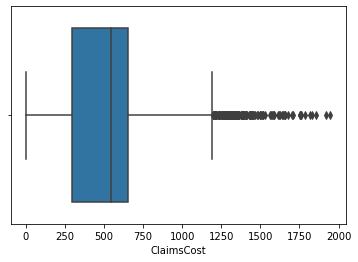

In [109]:
sns.boxplot(data= data_prep, x='ClaimsCost')
plt.show()

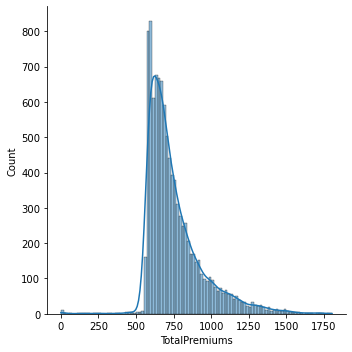

In [110]:
##plot Total premiums
sns.displot(data= data_prep, x='TotalPremiums', kde=True)
plt.show()

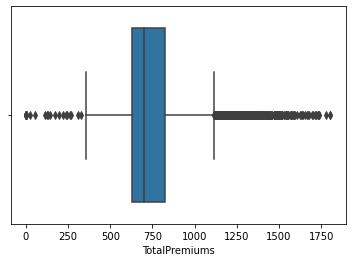

In [111]:
sns.boxplot(data= data_prep, x='TotalPremiums')
plt.show()

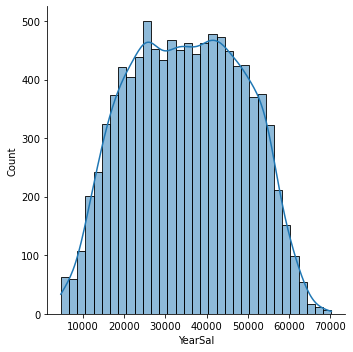

In [112]:
##plot Yearl Salary
sns.displot(data= data_prep, x='YearSal', kde=True)
plt.show()

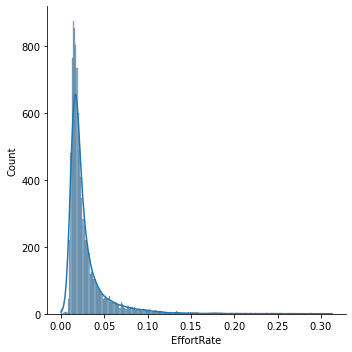

In [113]:
##plot effort rate
sns.displot(data= data_prep, x='EffortRate', kde=True)
plt.show()

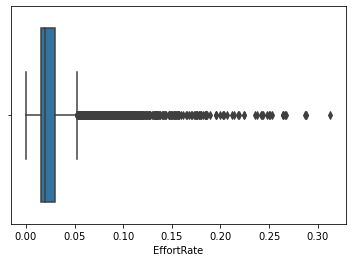

In [114]:
sns.boxplot(data=data_prep, x='EffortRate')
plt.show()

In [115]:
data_prep = data_prep[(data_prep['EffortRate']<=0.2) | (data_prep['EffortRate'].isna())]

In [116]:
print('we kept {:.2f} of the original data'.format((len(data_prep)/(len(dataset)+3))*100))

we kept 98.52 of the original data


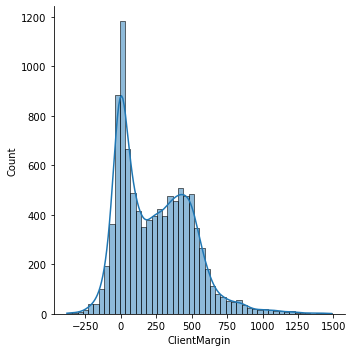

In [117]:
##plot effort rate
sns.displot(data= data_prep, x='ClientMargin', kde=True)
plt.show()

<AxesSubplot:xlabel='CustMonVal', ylabel='TotalPremiums'>

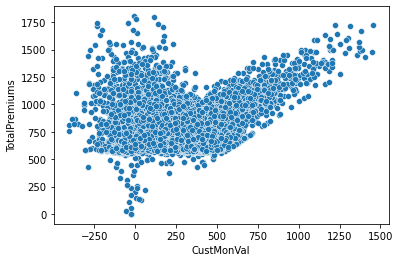

In [118]:
sns.scatterplot(data=data_prep, x='CustMonVal', y='TotalPremiums')

In [119]:
data_prep.describe().T

count          mean           std        min           25%  \
MonthSal         10144.0   2513.079879    974.201747   333.0000   1728.750000   
GeoLivArea       10144.0      2.708005      1.266403     1.0000      1.000000   
Children         10144.0      0.708103      0.454657     0.0000      0.000000   
CustMonVal       10144.0    216.150899    252.723863  -406.0700     -9.220000   
PremMotor        10144.0    298.447317    137.391930     0.0000    193.452500   
PremHousehold    10144.0    205.499532    224.153943     0.0000     48.900000   
PremHealth       10144.0    167.752267     74.759191     0.0000    111.800000   
PremLife         10144.0     40.180813     43.776747     0.0000      9.780000   
PremWork         10144.0     40.280666     44.621501     0.0000      9.890000   
ClientTenure     10144.0     29.970722      6.601936    18.0000     24.000000   
ClientAge        10144.0     48.163644     17.235488    15.0000     33.000000   
Cancelled        10144.0      0.218849      0.413486     0.0000      0.000000   
Educ_Basic       10144.0      0.117606      0.322157     0.0000      0.000000   
Educ_BscMsc      10144.0      0.471116      0.499190     0.0000      0.000000   
Educ_HighSchool  10144.0      0.342567      0.474591     0.0000      0.000000   
Educ_PhD         10144.0      0.068711      0.252974     0.0000      0.000000   
LivArea_1        10144.0      0.296333      0.456662     0.0000      0.000000   
LivArea_2        10144.0      0.101439      0.301924     0.0000      0.000000   
LivArea_3        10144.0      0.200118      0.400108     0.0000      0.000000   
LivArea_4        10144.0      0.402110      0.490348     0.0000      0.000000   
TotalPremiums    10144.0    752.160595    184.281349     0.0000    627.007500   
ClaimsCost       10144.0    509.918072    267.512667     0.0000    293.817500   
ClientMargin     10144.0    242.242524    253.977090  -379.7224     15.842000   
YearSal          10144.0  35183.118311  13638.824454  4662.0000  24202.500000   
EffortRate       10144.0      0.027556      0.021995     0.0000      0.015351   

                          50%           75%           max  
MonthSal          2516.000000   3294.250000   5021.000000  
GeoLivArea           3.000000      4.000000      4.000000  
Children             1.000000      1.000000      1.000000  
CustMonVal         186.265000    397.782500   1455.940000  
PremMotor          300.335000    408.410000    585.220000  
PremHousehold      132.250000    285.050000   1498.050000  
PremHealth         162.920000    219.820000    442.860000  
PremLife            24.670000     56.010000    248.270000  
PremWork            25.450000     55.120000    298.500000  
ClientTenure        30.000000     36.000000     42.000000  
ClientAge           49.000000     63.000000     81.000000  
Cancelled            0.000000      0.000000      1.000000  
Educ_Basic           0.000000      0.000000      1.000000  
Educ_BscMsc          0.000000      1.000000      1.000000  
Educ_HighSchool      0.000000      1.000000      1.000000  
Educ_PhD             0.000000      0.000000      1.000000  
LivArea_1            0.000000      1.000000      1.000000  
LivArea_2            0.000000      0.000000      1.000000  
LivArea_3            0.000000      0.000000      1.000000  
LivArea_4            0.000000      1.000000      1.000000  
TotalPremiums      696.800000    820.955000   1803.880000  
ClaimsCost         545.920650    653.357700   1946.918400  
ClientMargin       212.389050    427.180350   1486.355200  
YearSal          35224.000000  46119.500000  70294.000000  
EffortRate           0.019878      0.030229      0.199501

In [120]:
print(data_prep.shape)

(10144, 26)


In [121]:
## create new variables

## client has specific LoB

data_prep['HasMotor'] = np.where(data_prep['PremMotor']>0,1,0)
data_prep['HasHome'] = np.where(data_prep['PremHousehold']>0,1,0)
data_prep['HasHealth'] = np.where(data_prep['PremHealth']>0,1,0)
data_prep['HasLife'] = np.where(data_prep['PremLife']>0,1,0)
data_prep['HasWork'] = np.where(data_prep['PremWork']>0,1,0)

## total number of LoB
data_prep['NumberProducts'] = data_prep['HasMotor']+data_prep['HasHome']+data_prep['HasHealth']+data_prep['HasLife']+data_prep['HasWork']

## is the client multi-product

#data_prep['IsEquiped'] = np.where(data_prep['NumberProducts']>1,1,0)

# average premium
# data_prep['AveragePremium'] = data_prep['TotalPremiums']/data_prep['NumberProducts']

## proportions of products

# data_prep['ProdMotorProp'] = data_prep['HasMotor']/data_prep['NumberProducts']
# data_prep['ProdHouseholdProp'] = data_prep['HasHome']/data_prep['NumberProducts']
# data_prep['ProdHealthProp'] = data_prep['HasHealth']/data_prep['NumberProducts']
# data_prep['ProdLifeProp'] = data_prep['HasLife']/data_prep['NumberProducts']
# data_prep['ProdWorkProp'] = data_prep['HasWork']/data_prep['NumberProducts']

## proportions of premiums

# data_prep['PremMotorProp'] = data_prep['PremMotor']/data_prep['TotalPremiums']
# data_prep['PremHouseholdProp'] = data_prep['PremHousehold']/data_prep['TotalPremiums']
# data_prep['PremHealthProp'] = data_prep['PremHealth']/data_prep['TotalPremiums']
# data_prep['PremLifeProp'] = data_prep['PremLife']/data_prep['TotalPremiums']
# data_prep['PremWorkProp'] = data_prep['PremWork']/data_prep['TotalPremiums']

In [122]:
data_prep.describe().T

count          mean           std        min           25%  \
MonthSal         10144.0   2513.079879    974.201747   333.0000   1728.750000   
GeoLivArea       10144.0      2.708005      1.266403     1.0000      1.000000   
Children         10144.0      0.708103      0.454657     0.0000      0.000000   
CustMonVal       10144.0    216.150899    252.723863  -406.0700     -9.220000   
PremMotor        10144.0    298.447317    137.391930     0.0000    193.452500   
PremHousehold    10144.0    205.499532    224.153943     0.0000     48.900000   
PremHealth       10144.0    167.752267     74.759191     0.0000    111.800000   
PremLife         10144.0     40.180813     43.776747     0.0000      9.780000   
PremWork         10144.0     40.280666     44.621501     0.0000      9.890000   
ClientTenure     10144.0     29.970722      6.601936    18.0000     24.000000   
ClientAge        10144.0     48.163644     17.235488    15.0000     33.000000   
Cancelled        10144.0      0.218849      0.413486     0.0000      0.000000   
Educ_Basic       10144.0      0.117606      0.322157     0.0000      0.000000   
Educ_BscMsc      10144.0      0.471116      0.499190     0.0000      0.000000   
Educ_HighSchool  10144.0      0.342567      0.474591     0.0000      0.000000   
Educ_PhD         10144.0      0.068711      0.252974     0.0000      0.000000   
LivArea_1        10144.0      0.296333      0.456662     0.0000      0.000000   
LivArea_2        10144.0      0.101439      0.301924     0.0000      0.000000   
LivArea_3        10144.0      0.200118      0.400108     0.0000      0.000000   
LivArea_4        10144.0      0.402110      0.490348     0.0000      0.000000   
TotalPremiums    10144.0    752.160595    184.281349     0.0000    627.007500   
ClaimsCost       10144.0    509.918072    267.512667     0.0000    293.817500   
ClientMargin     10144.0    242.242524    253.977090  -379.7224     15.842000   
YearSal          10144.0  35183.118311  13638.824454  4662.0000  24202.500000   
EffortRate       10144.0      0.027556      0.021995     0.0000      0.015351   
HasMotor         10144.0      0.996550      0.058641     0.0000      1.000000   
HasHome          10144.0      0.886632      0.317057     0.0000      1.000000   
HasHealth        10144.0      0.995761      0.064972     0.0000      1.000000   
HasLife          10144.0      0.924192      0.264704     0.0000      1.000000   
HasWork          10144.0      0.901222      0.298378     0.0000      1.000000   
NumberProducts   10144.0      4.704357      0.592467     0.0000      5.000000   

                          50%           75%           max  
MonthSal          2516.000000   3294.250000   5021.000000  
GeoLivArea           3.000000      4.000000      4.000000  
Children             1.000000      1.000000      1.000000  
CustMonVal         186.265000    397.782500   1455.940000  
PremMotor          300.335000    408.410000    585.220000  
PremHousehold      132.250000    285.050000   1498.050000  
PremHealth         162.920000    219.820000    442.860000  
PremLife            24.670000     56.010000    248.270000  
PremWork            25.450000     55.120000    298.500000  
ClientTenure        30.000000     36.000000     42.000000  
ClientAge           49.000000     63.000000     81.000000  
Cancelled            0.000000      0.000000      1.000000  
Educ_Basic           0.000000      0.000000      1.000000  
Educ_BscMsc          0.000000      1.000000      1.000000  
Educ_HighSchool      0.000000      1.000000      1.000000  
Educ_PhD             0.000000      0.000000      1.000000  
LivArea_1            0.000000      1.000000      1.000000  
LivArea_2            0.000000      0.000000      1.000000  
LivArea_3            0.000000      0.000000      1.000000  
LivArea_4            0.000000      1.000000      1.000000  
TotalPremiums      696.800000    820.955000   1803.880000  
ClaimsCost         545.920650    653.357700   1946.918400  
ClientMargin       212.389050    427.180350   

In [123]:
data_prep.loc[:,['HasMotor','HasHealth','HasHome','HasLife','HasWork']].value_counts().sort_index()

HasMotor  HasHealth  HasHome  HasLife  HasWork
0         0          0        0        0            12
                              1        1             1
          1          0        0        1             1
                              1        1             3
                     1        0        1             1
                              1        0             4
                                       1            13
1         0          0        0        0             1
                                       1             1
                              1        1             5
                     1        0        1             2
                              1        0             2
                                       1            19
          1          0        0        0            57
                                       1           125
                              1        0           162
                                       1           782
                  

- only 9 clients dont have a motor policy
- only 1 client has only motor
- most of the clients own motor and health 

In [124]:
##plot effort rate
# sns.displot(data= data_prep, x='AveragePremium', kde=True)
# plt.show()

In [125]:
## there are clients with no active policies
data_prep[data_prep['NumberProducts']<2]

EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  PremMotor  \
index                                                                      
862        BscMsc    2127.0           1       1.0      -25.00       0.00   
1133       BscMsc    3560.0           2       0.0      -25.00       0.00   
2958       BscMsc    1938.0           1       1.0      -87.54     390.52   
3165   HighSchool    1813.0           4       1.0      -25.00       0.00   
4022       BscMsc    1296.0           3       1.0      -25.00       0.00   
4113   HighSchool    1073.0           1       1.0      -25.00       0.00   
4271       BscMsc    1458.0           1       1.0      -25.00       0.00   
5983       BscMsc    2745.0           3       0.0      -25.00       0.00   
6439       BscMsc    2375.0           2       1.0      -25.00       0.00   
6614        Basic    1231.0           1       1.0      -25.00       0.00   
8585       BscMsc    3269.0           1       0.0      -25.00       0.00   
9398        Basic    2170.0           3       0.0      -25.00       0.00   
9788       BscMsc    4050.0           1       0.0      -25.00       0.00   

       PremHousehold  PremHealth  PremLife  PremWork  ...  ClaimsCost  \
index                                                 ...               
862              0.0         0.0       0.0       0.0  ...      0.0000   
1133             0.0         0.0       0.0       0.0  ...      0.0000   
2958             0.0         0.0       0.0       0.0  ...    456.9084   
3165             0.0         0.0       0.0       0.0  ...      0.0000   
4022             0.0         0.0       0.0       0.0  ...      0.0000   
4113             0.0         0.0       0.0       0.0  ...      0.0000   
4271             0.0         0.0       0.0       0.0  ...      0.0000   
5983             0.0         0.0       0.0       0.0  ...      0.0000   
6439             0.0         0.0       0.0       0.0  ...      0.0000   
6614             0.0         0.0       0.0       0.0  ...      0.0000   
8585             0.0         0.0       0.0       0.0  ...      0.0000   
9398             0.0         0.0       0.0       0.0  ...      0.0000   
9788             0.0         0.0       0.0       0.0  ...      0.0000   

       ClientMargin  YearSal  EffortRate  HasMotor  HasHome  HasHealth  \
index                                                                    
862          0.0000  29778.0    0.000000         0        0          0   
1133         0.0000  49840.0    0.000000         0        0          0   
2958       -66.3884  27132.0    0.014393         1        0          0   
3165         0.0000  25382.0    0.000000         0        0          0   
4022         0.0000  18144.0    0.000000         0        0          0   
4113         0.0000  15022.0    0.000000         0        0          0   
4271         0.0000  20412.0    0.000000         0        0          0   
5983         0.0000  38430.0    0.000000         0        0          0   
6439         0.0000  33250.0    0.000000         0        0          0   
6614         0.0000  17234.0    0.000000         0        0          0   
8585         0.0000  45766.0    0.000000         0        0          0   
9398         0.0000  30380.0    0.000000         0        0          0   
9788         0.0000  56700.0    0.000000         0        0          0   

       HasLife  HasWork  NumberProducts  
index                                    
862          0        0               0  
1133         0        0               0  
2958         0        0               1  
3165         0        0               0  
4022         0        0               0  
4113         0        0               0  
4271         0        0               0  
5983         0        0               0  
6439         0        0               0  
6614         0        0               0  
8585         0        0               0  
9398         0        0               0  
9788         0        0               0  

[13 rows x 32 columns]

In [126]:
data_prep = data_prep.loc[data_prep['NumberProducts']>0]

In [127]:
print('we kept {:.2f} of the original data'.format((len(data_prep)/(len(dataset)+3))*100))

we kept 98.41 of the original data


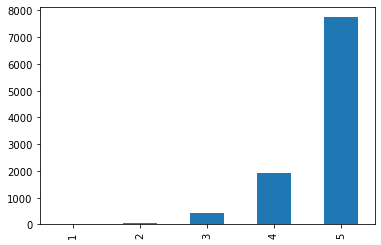

In [128]:
data_prep['NumberProducts'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [129]:
data_prep.NumberProducts.value_counts(normalize=True)

5    0.763324
4    0.189400
3    0.041255
2    0.005922
1    0.000099
Name: NumberProducts, dtype: float64

## Applying Clustering

In [130]:
data_prep.columns

Index(['EducDeg', 'MonthSal', 'GeoLivArea', 'Children', 'CustMonVal',
       'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork',
       'ClientTenure', 'ClientAge', 'Cancelled', 'Educ_Basic', 'Educ_BscMsc',
       'Educ_HighSchool', 'Educ_PhD', 'LivArea_1', 'LivArea_2', 'LivArea_3',
       'LivArea_4', 'TotalPremiums', 'ClaimsCost', 'ClientMargin', 'YearSal',
       'EffortRate', 'HasMotor', 'HasHome', 'HasHealth', 'HasLife', 'HasWork',
       'NumberProducts'],
      dtype='object')

In [131]:
pair_features = ['PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork','ClientTenure', 'ClientAge', 'TotalPremiums', 'CustMonVal', 'YearSal','NumberProducts','Cancelled','EffortRate']

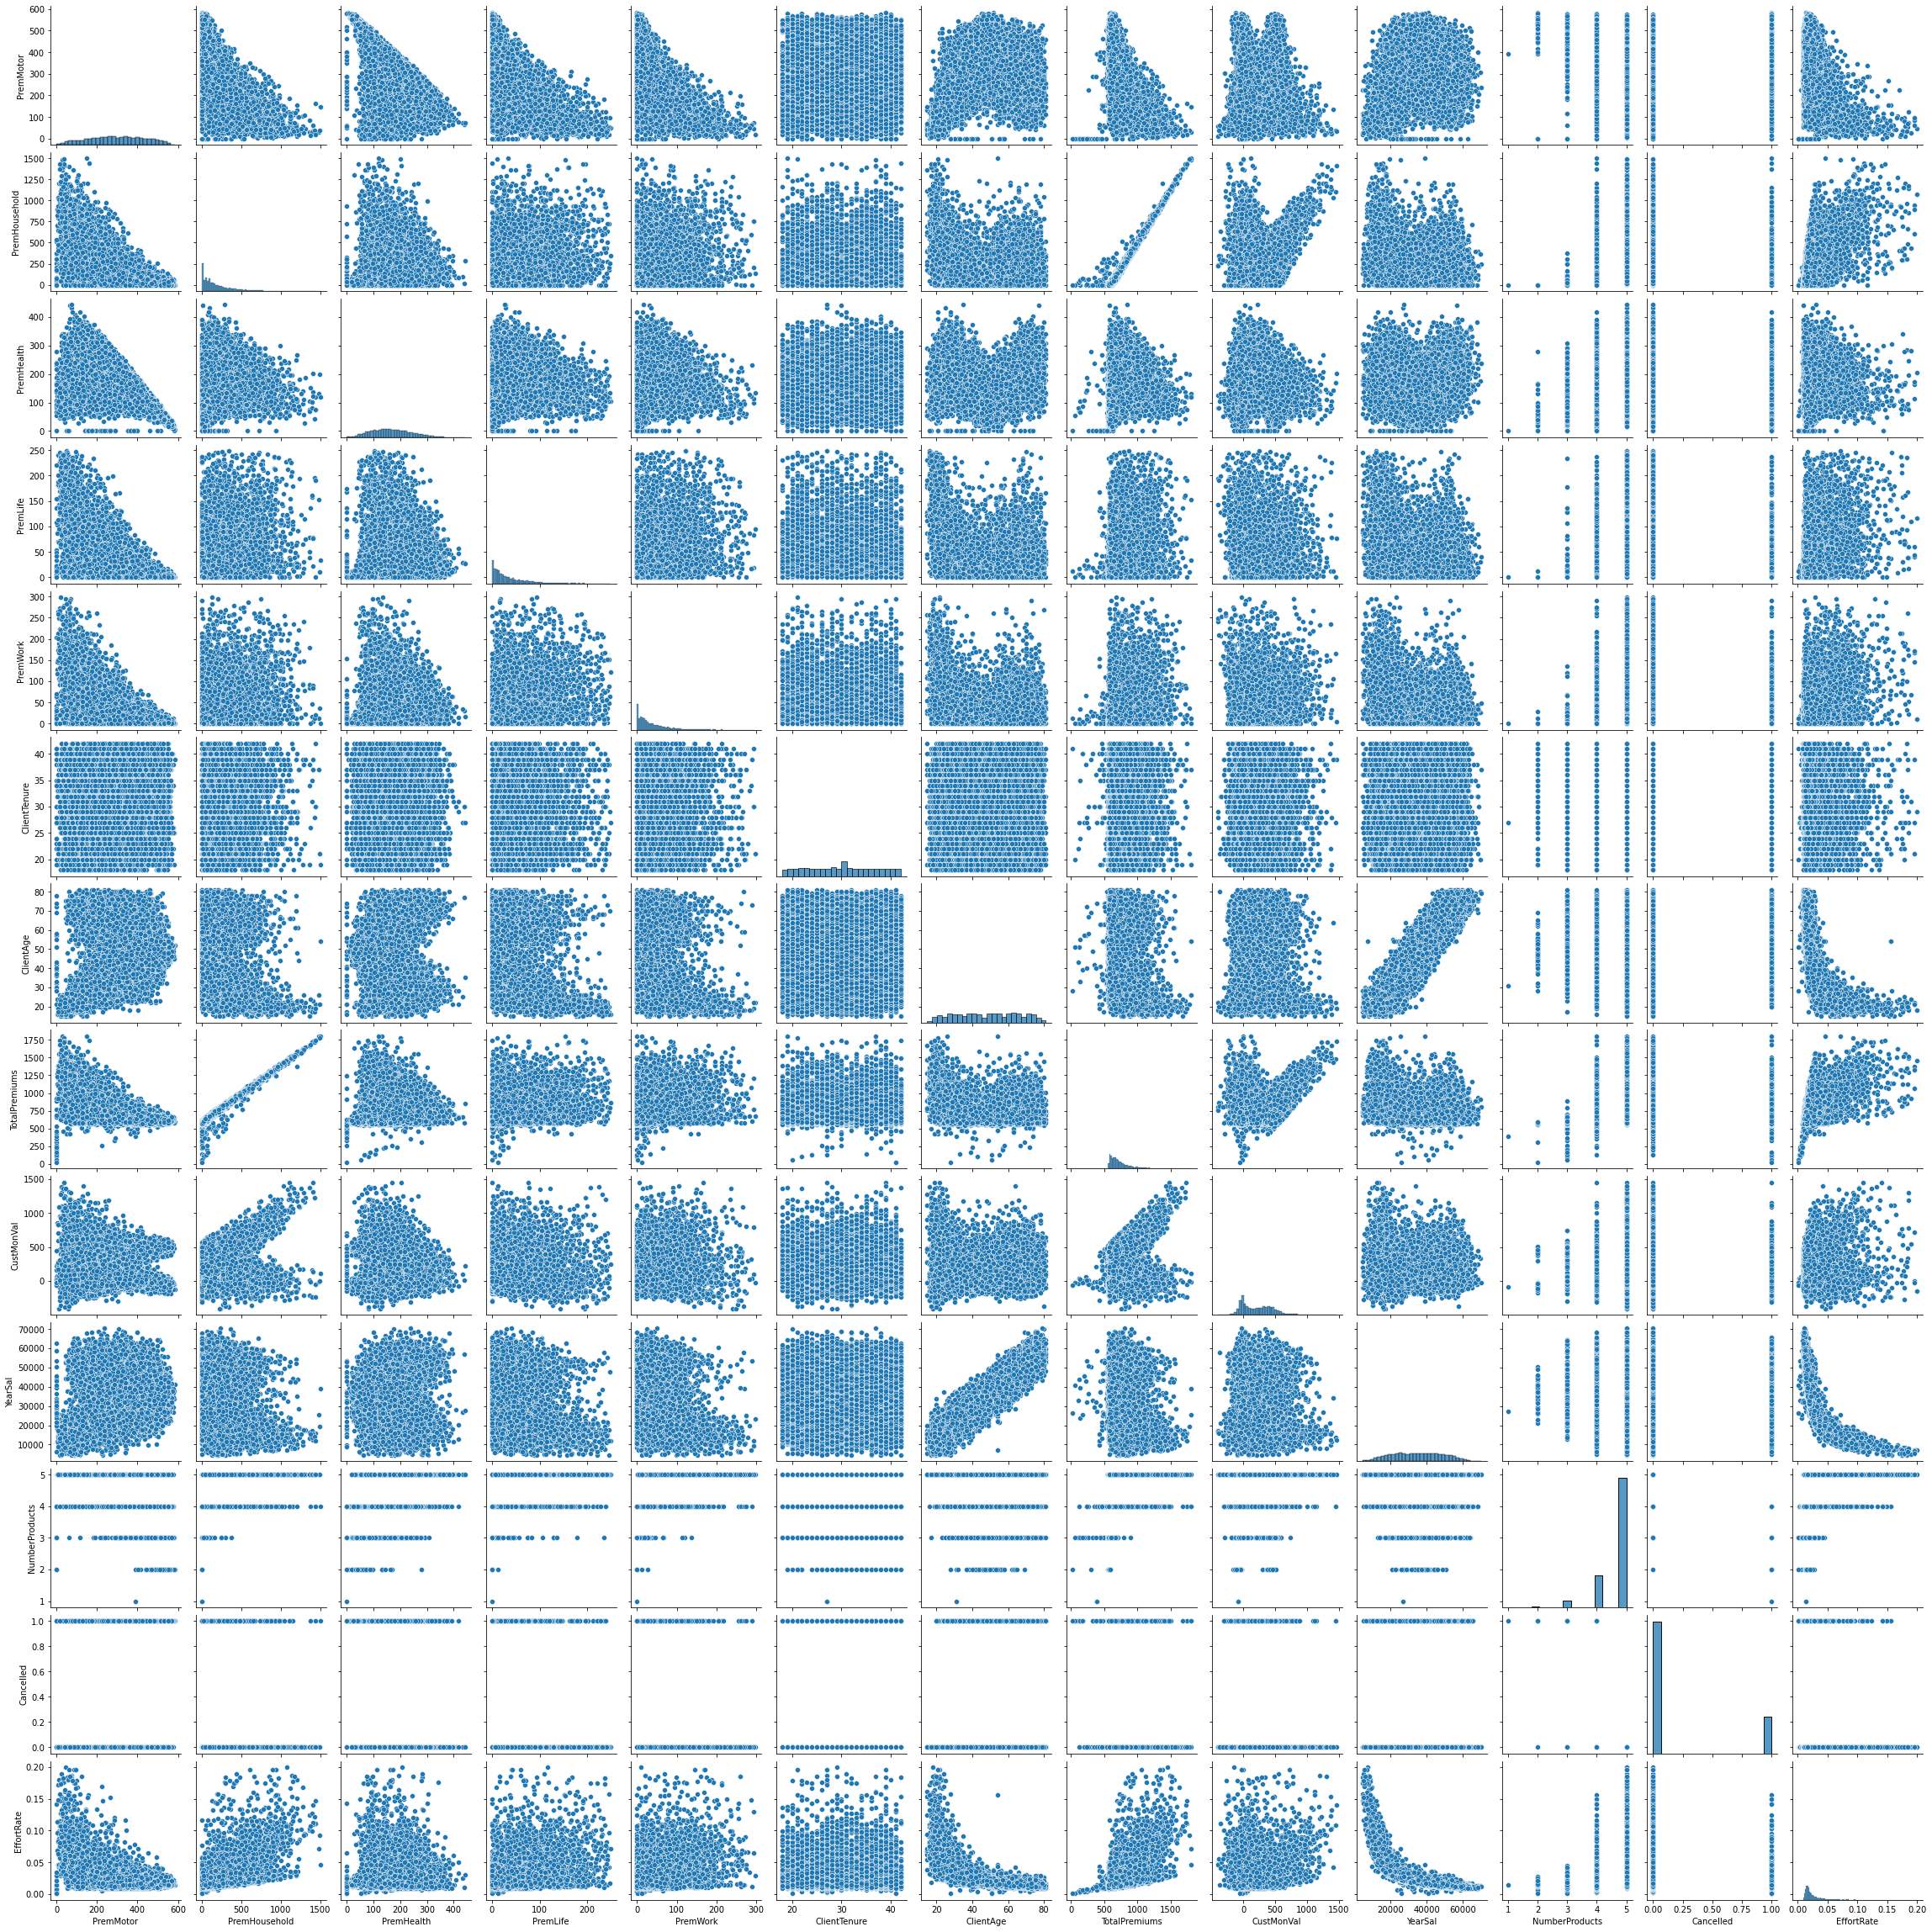

In [132]:
sns.pairplot(data_prep[pair_features])
plt.show()

In [134]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10132 entries, 0 to 10295
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EducDeg          10132 non-null  object 
 1   MonthSal         10132 non-null  float64
 2   GeoLivArea       10132 non-null  int32  
 3   Children         10132 non-null  float64
 4   CustMonVal       10132 non-null  float64
 5   PremMotor        10132 non-null  float64
 6   PremHousehold    10132 non-null  float64
 7   PremHealth       10132 non-null  float64
 8   PremLife         10132 non-null  float64
 9   PremWork         10132 non-null  float64
 10  ClientTenure     10132 non-null  float64
 11  ClientAge        10132 non-null  float64
 12  Cancelled        10132 non-null  int32  
 13  Educ_Basic       10132 non-null  uint8  
 14  Educ_BscMsc      10132 non-null  uint8  
 15  Educ_HighSchool  10132 non-null  uint8  
 16  Educ_PhD         10132 non-null  uint8  
 17  LivArea_1   

In [135]:
df_train = data_prep.copy()

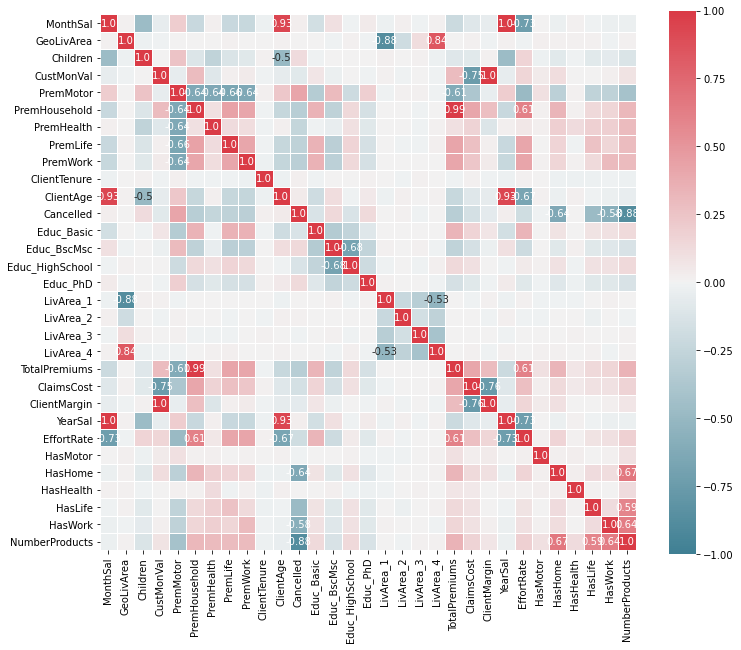

In [136]:
# builds correlation matrix
corre = round(df_train.corr(),2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corre.values) >= 0.5
annot = np.where(mask_annot, corre.values, np.full(corre.shape,"")) # Try to understand what this np.where() does

# Prepare figure
fig = plt.figure(figsize=(12, 10))
# Plot heatmap of the correlation matrix
sns.heatmap(data=corre, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

 - High premiums of motor means lower premiums of other products (high correlation)

In [137]:
df_train.isna().sum()

EducDeg            0
MonthSal           0
GeoLivArea         0
Children           0
CustMonVal         0
PremMotor          0
PremHousehold      0
PremHealth         0
PremLife           0
PremWork           0
ClientTenure       0
ClientAge          0
Cancelled          0
Educ_Basic         0
Educ_BscMsc        0
Educ_HighSchool    0
Educ_PhD           0
LivArea_1          0
LivArea_2          0
LivArea_3          0
LivArea_4          0
TotalPremiums      0
ClaimsCost         0
ClientMargin       0
YearSal            0
EffortRate         0
HasMotor           0
HasHome            0
HasHealth          0
HasLife            0
HasWork            0
NumberProducts     0
dtype: int64

In [140]:
df_train.drop(columns=['EducDeg'], inplace=True)

In [163]:
df_train.Cancelled.value_counts()

-0.529704    7912
 1.887846    2220
Name: Cancelled, dtype: int64

In [141]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns, index=df_train.index)

In [142]:
df_train.head()

MonthSal  GeoLivArea  Children  CustMonVal  PremMotor  PremHousehold  \
index                                                                         
0     -0.345296   -1.349562  0.641817    0.651039   0.562067      -0.563395   
1     -1.885077    1.019556  0.641817   -1.375278  -1.614662       0.938853   
2     -0.242644    0.229850 -1.558077    1.140504  -0.675880       0.083676   
3     -1.451885    1.019556  0.641817   -0.923640  -0.848550      -0.724438   
4     -0.770275    1.019556  0.641817   -0.717012   0.290478      -0.704587   

       PremHealth  PremLife  PremWork  ClientTenure  ...  ClaimsCost  \
index                                                ...               
0       -0.289515  0.154907 -0.525239      0.155790  ...   -0.939615   
1       -0.687362  3.523444  1.474574      0.761901  ...    1.908607   
2       -0.581564  1.053518  1.315243     -0.753376  ...   -1.135063   
3        1.920435 -0.111662 -0.268652     -0.601848  ...    0.315077   
4        0.196296 -0.489928  0.025135      0.004262  ...    0.208903   

       ClientMargin   YearSal  EffortRate  HasMotor   HasHome  HasHealth  \
index                                                                      
0          0.643608 -0.345296   -0.261597  0.047699  0.355709   0.055399   
1         -1.385335 -1.885077    3.116640  0.047699  0.355709   0.055399   
2          1.144598 -0.242644   -0.198152  0.047699  0.355709   0.055399   
3         -0.931272 -1.451885    0.520850  0.047699  0.355709   0.055399   
4         -0.707169 -0.770275   -0.095291  0.047699  0.355709   0.055399   

       HasLife   HasWork  NumberProducts  
index                                     
0      0.28416  0.329077        0.508696  
1      0.28416  0.329077        0.508696  
2      0.28416  0.329077        0.508696  
3      0.28416  0.329077        0.508696  
4      0.28416  0.329077        0.508696  

[5 rows x 31 columns]

Start applying alghoritms.

### Product Segmentation

In [143]:
features = ['PremHousehold','PremHealth','PremLife','PremWork']

In [144]:
df_train2 = df_train[features]

In [145]:
df_train2.head()

PremHousehold  PremHealth  PremLife  PremWork
index                                               
0          -0.563395   -0.289515  0.154907 -0.525239
1           0.938853   -0.687362  3.523444  1.474574
2           0.083676   -0.581564  1.053518  1.315243
3          -0.724438    1.920435 -0.111662 -0.268652
4          -0.704587    0.196296 -0.489928  0.025135

In [146]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

In [ ]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_train2)
    sse.append(kmeans.inertia_)

In [ ]:
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Looks like its 3 but lets confirm:

In [ ]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

In [ ]:
# # A list holds the silhouette coefficients for each k
# silhouette_coefficients = []

# # Notice you start at 2 clusters for silhouette coefficient
# for k in range(2, 10):
#     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#     kmeans.fit(df_train2)
#     score = silhouette_score(df_train2, kmeans.labels_)
#     silhouette_coefficients.append(score)

In [ ]:
# plt.style.use("seaborn")
# plt.plot(range(2, 10), silhouette_coefficients)
# plt.xticks(range(2, 10))
# plt.title("Silhouette Graph")
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Coefficient")
# plt.show()

By the silhouette graph its clear that we shoud use 4 clusters

In [ ]:
kmeans = KMeans(init="random", n_clusters=3, n_init=10, max_iter=300,random_state=42)

In [ ]:
kmeans.fit(df_train2)

In [ ]:
# The lowest SSE value
kmeans.inertia_

In [ ]:
# Final locations of the centroid
kmeans.cluster_centers_

In [ ]:
# The number of iterations required to converge
kmeans.n_iter_

In [ ]:
kmeans.labels_

In [ ]:
# from scipy import stats
np.unique(kmeans.labels_, return_counts=True)

In [ ]:
df_train3 = pd.DataFrame(scaler.inverse_transform(df_train), columns=df_train.columns, index=df_train.index)

In [ ]:
df_train3 = df_train3[features+['PremMotor']]

In [ ]:
## adding the cluster to the dataframe
df_cluster = pd.concat([df_train3, pd.Series(kmeans.labels_,name='ClusterID', index=df_train3.index)], axis=1)

In [ ]:
df_cluster.groupby('ClusterID').agg('mean').T

### Value Segmentation

In [147]:
value_features = ['TotalPremiums','ClaimsCost','YearSal','EffortRate','NumberProducts']

In [148]:
df_value = df_train[value_features]

In [149]:
df_value.head()

TotalPremiums  ClaimsCost   YearSal  EffortRate  NumberProducts
index                                                                 
0          -0.479266   -0.939615 -0.345296   -0.261597        0.508696
1           0.865001    1.908607 -1.885077    3.116640        0.508696
2          -0.068207   -1.135063 -0.242644   -0.198152        0.508696
3          -0.834669    0.315077 -1.451885    0.520850        0.508696
4          -0.678221    0.208903 -0.770275   -0.095291        0.508696

In [150]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_value)
    sse.append(kmeans.inertia_)

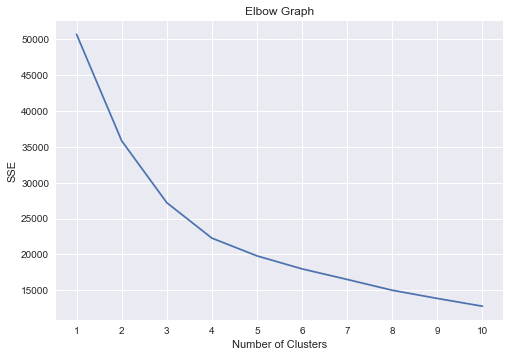

In [151]:
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [152]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [153]:
kmeans_value = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300,random_state=42)

In [154]:
kmeans_value.fit(df_value)

KMeans(init='random', n_clusters=4, random_state=42)

In [155]:
# from scipy import stats
np.unique(kmeans_value.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([3110,  978, 3813, 2231], dtype=int64))

In [156]:
df_train3 = pd.DataFrame(scaler.inverse_transform(df_train), columns=df_train.columns, index=df_train.index)

In [157]:
## adding the cluster to the dataframe
df_cluster_value = pd.concat([df_train3, pd.Series(kmeans_value.labels_,name='ClusterID', index=df_train3.index)], axis=1)

In [158]:
df_cluster_value.head()

MonthSal  GeoLivArea  Children  CustMonVal  PremMotor  PremHousehold  \
index                                                                         
0        2177.0         1.0       1.0      380.97     375.85          79.45   
1         677.0         4.0       1.0     -131.13      77.46         416.20   
2        2277.0         3.0       0.0      504.67     206.15         224.50   
3        1099.0         4.0       1.0      -16.99     182.48          43.35   
4        1763.0         4.0       1.0       35.23     338.62          47.80   

       PremHealth  PremLife  PremWork  ClientTenure  ...  ClientMargin  \
index                                                ...                 
0          146.36     47.01     16.89          31.0  ...      405.9916   
1          116.69    194.48    106.13          35.0  ...     -109.3152   
2          124.58     86.35     99.02          25.0  ...      533.2320   
3          311.17     35.34     28.34          26.0  ...        6.0068   
4          182.59     18.78     41.45          30.0  ...       62.9240   

       YearSal  EffortRate  HasMotor  HasHome  HasHealth  HasLife  HasWork  \
index                                                                        
0      30478.0    0.021837       1.0      1.0        1.0      1.0      1.0   
1       9478.0    0.096113       1.0      1.0        1.0      1.0      1.0   
2      31878.0    0.023232       1.0      1.0        1.0      1.0      1.0   
3      15386.0    0.039041       1.0      1.0        1.0      1.0      1.0   
4      24682.0    0.025494       1.0      1.0        1.0      1.0      1.0   

       NumberProducts  ClusterID  
index                             
0                 5.0          0  
1                 5.0          1  
2                 5.0          0  
3                 5.0          0  
4                 5.0          0  

[5 rows x 32 columns]

In [159]:
df_cluster_value = df_cluster_value[value_features+['ClusterID']]

In [161]:
df_cluster_value.groupby('ClusterID').agg('mean')

TotalPremiums  ClaimsCost       YearSal  EffortRate  NumberProducts
ClusterID                                                                     
0             728.298068  479.318696  24902.244460    0.031737        4.979100
1            1119.199029  788.988928  16400.957055    0.079364        4.956033
2             757.883168  524.230901  47670.372976    0.016208        4.984527
3             618.791986  408.518232  36424.906193    0.018562        3.757508

In [162]:
df_cluster_value.groupby('ClusterID').size()

ClusterID
0    3110
1     978
2    3813
3    2231
dtype: int64